In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from scipy import stats
from matplotlib.patches import Rectangle

In [2]:
## Wczytywanie wyników

raw_data = pd.read_csv("wyniki.csv", decimal=",")
questions = raw_data[[c for c in raw_data if c.startswith('Q_')]]
control_q = raw_data[[c for c in raw_data if c.startswith('CQ_')]]
mfq = raw_data[[c for c in raw_data if c.startswith('MFQ_')]]

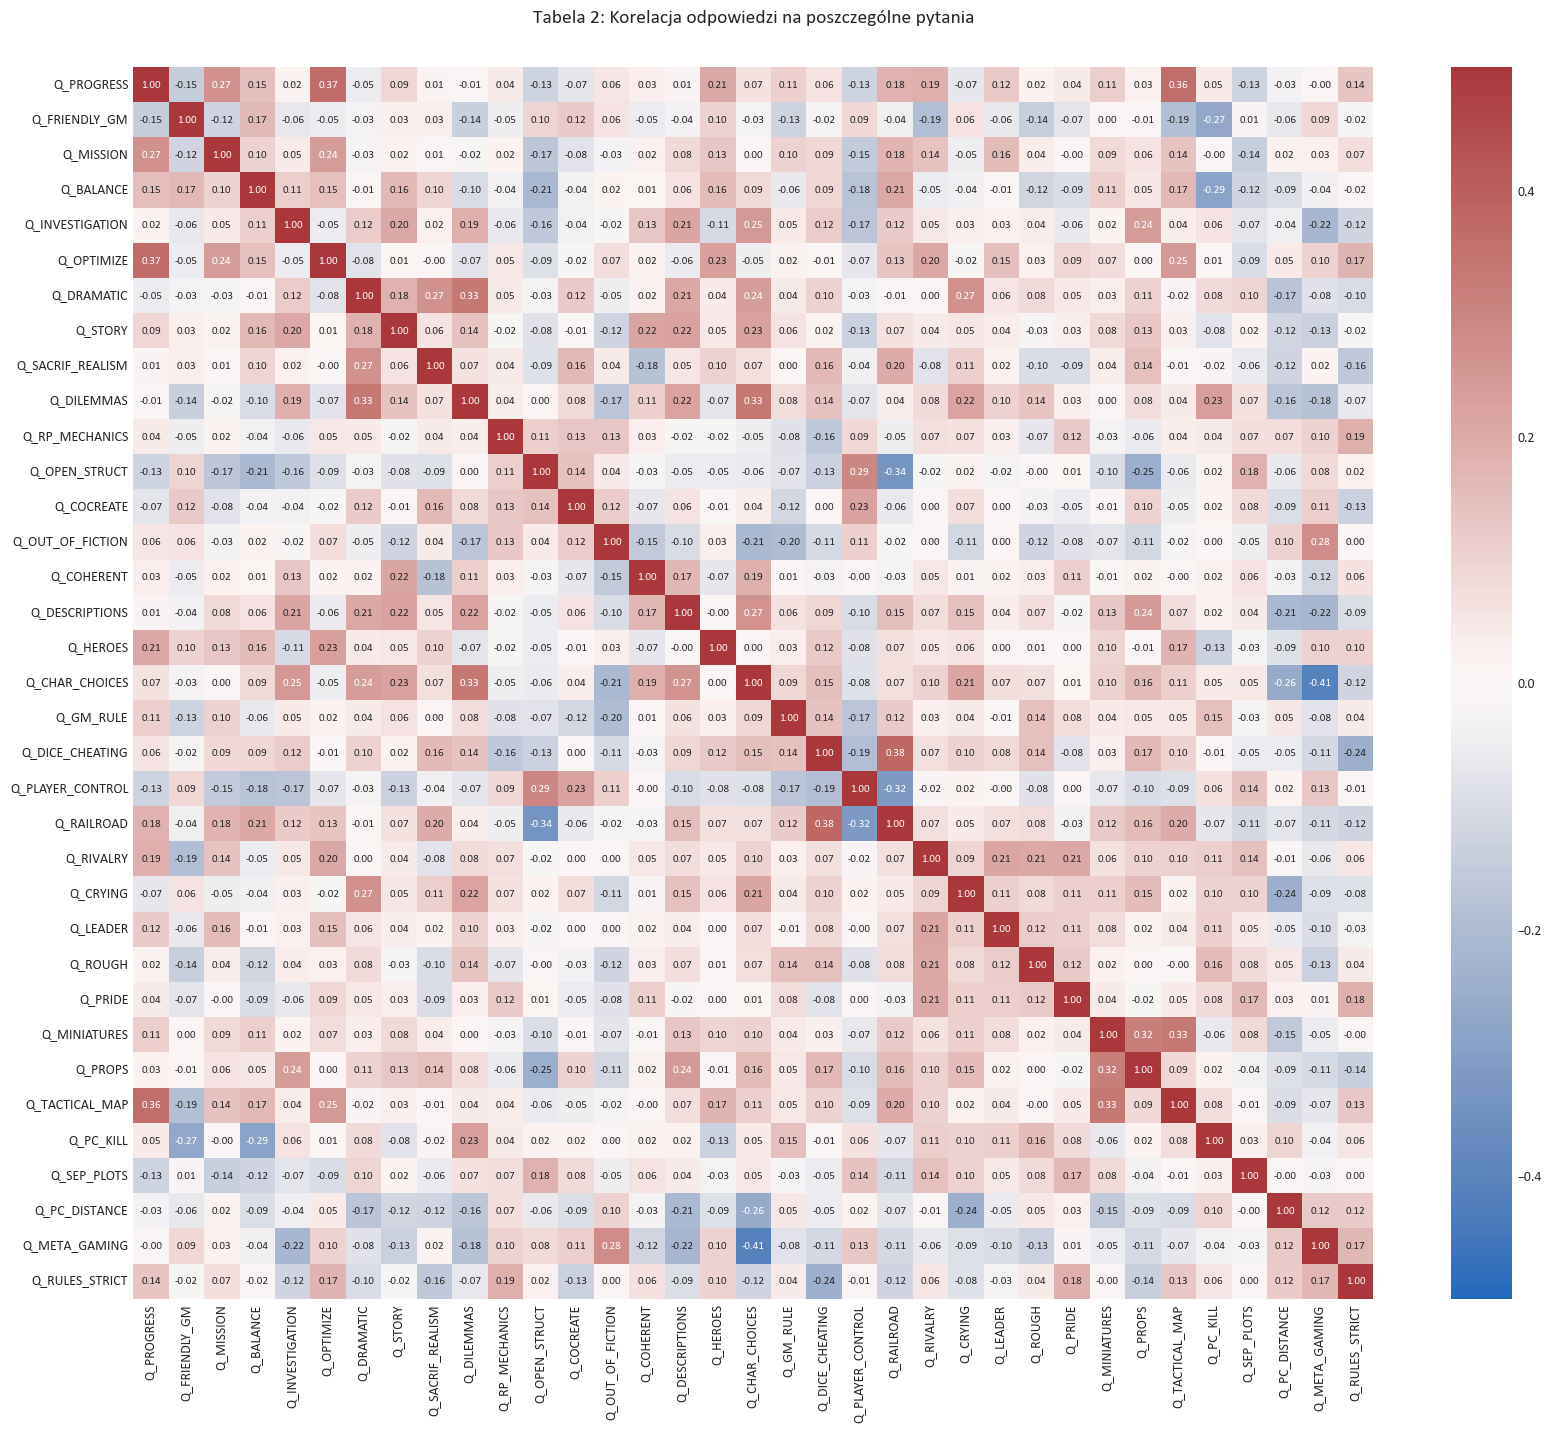

In [3]:
## Tabela 2: Korelacja odpowiedzi na poszczególne pytania

plt.style.use('seaborn-v0_8-dark')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Calibri', 'Lucida Grande', 'Verdana']

fig, ax = plt.subplots(figsize=(20, 16))
sb.heatmap(questions.corr(), cmap='vlag', annot=True, fmt='.2f', annot_kws={'fontsize': 8}, vmin=-0.5, vmax=0.5)
plt.tick_params(left=False, bottom=False)
ax.set_title('Tabela 2: Korelacja odpowiedzi na poszczególne pytania', fontsize=14, pad=32)
plt.show()

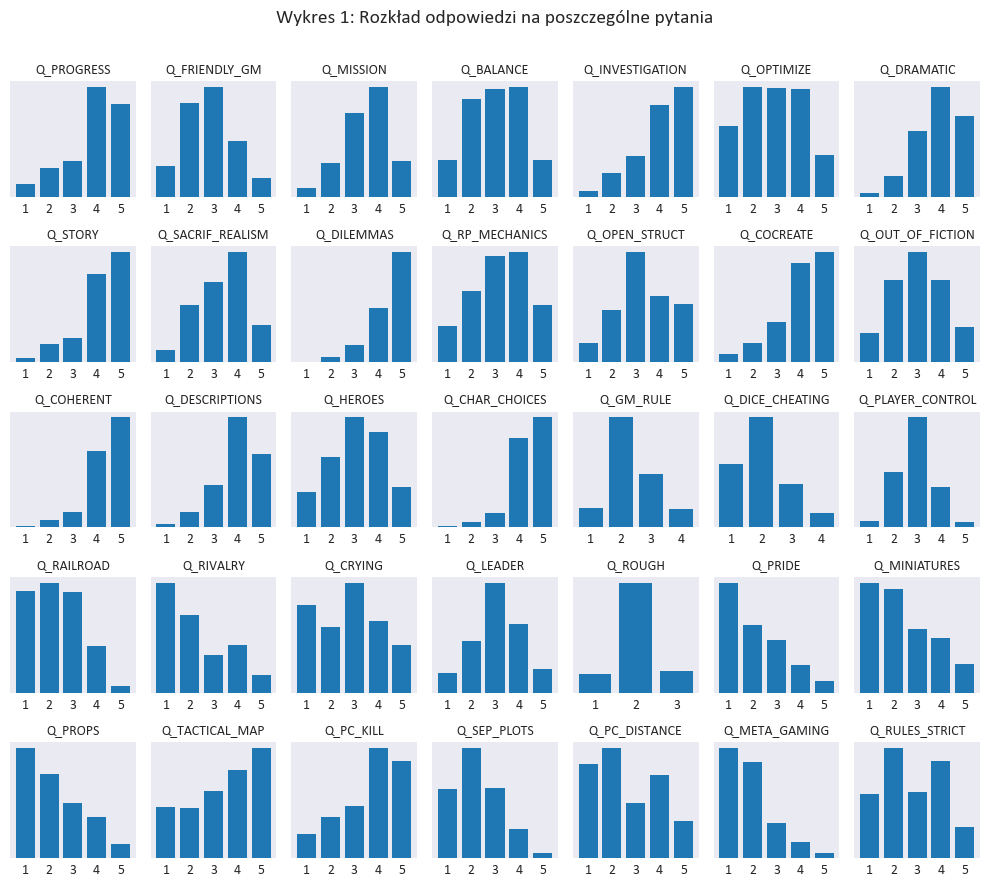

In [4]:
## Wykres 1: Rozkład odpowiedzi na poszczególne pytania

fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(10, 9))
for col, ax in zip(questions.columns, axes.flatten()):
    counts = questions[col].dropna().value_counts().sort_index()
    
    ax.bar(counts.index, counts.values)
    ax.set_title(col, fontsize=10)
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xticks(range(1, len(counts.index)+1))
    ax.set_xticklabels(counts.index.astype(int))
    ax.tick_params(left= False, bottom= False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)

fig.suptitle('Wykres 1: Rozkład odpowiedzi na poszczególne pytania', fontsize=14)
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [5]:
## Normalizacja i "imputowanie" brakujących wartości

q_scaled = (questions - questions.mean()) / questions.std()
imputer = KNNImputer(n_neighbors=5, weights="uniform")
q_imputed = pd.DataFrame(imputer.fit_transform(q_scaled), columns=q_scaled.columns)

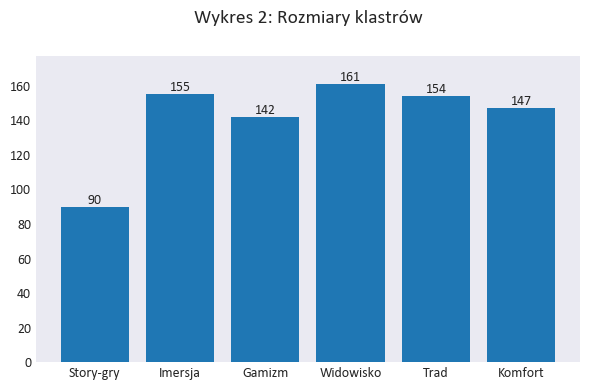

In [6]:
## Klastrowanie

np.random.seed(31122023)
kmeans = KMeans(n_clusters=6, n_init=100).fit(q_imputed)

cluster_names = ['Story-gry', 'Imersja', 'Gamizm', 'Widowisko', 'Trad', 'Komfort']
cluster_sizes = pd.Series(kmeans.labels_).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(cluster_names, cluster_sizes.values)
ax.bar_label(bars)
ax.set_title('Wykres 2: Rozmiary klastrów', fontsize=14, pad=24)
plt.ylim([0, cluster_sizes.max() * 1.1])
plt.tight_layout()
plt.show()

In [7]:
## Usunięcie przypadków brzegowych (outlierów)

dist_to_centroid = kmeans.transform(q_imputed)[tuple(zip(*enumerate(kmeans.labels_)))]
cluster_distances = pd.DataFrame({"Distance": dist_to_centroid, "Cluster": kmeans.labels_})

outlier_limits = cluster_distances.groupby('Cluster').quantile(.95).to_numpy()[:,0]
is_not_outlier = np.array([dist_to_centroid[i] <= outlier_limits[kmeans.labels_[i]] for i in range(len(dist_to_centroid))])
q_clustered = q_imputed.assign(CLUSTER=kmeans.labels_)[is_not_outlier]

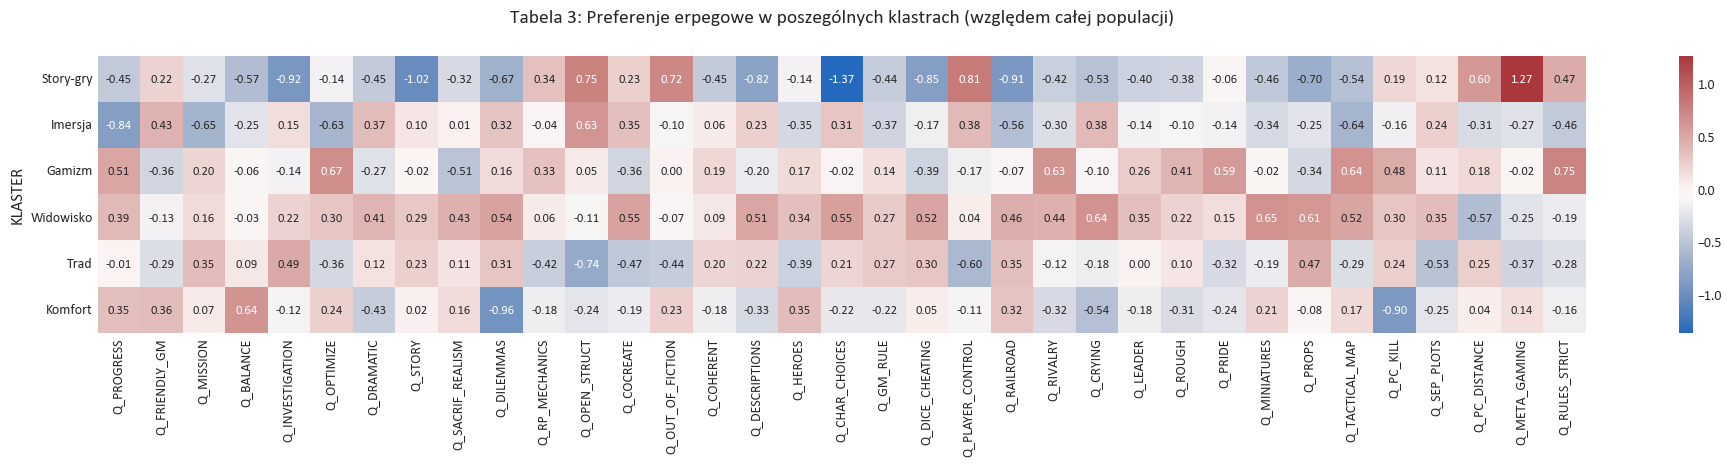

In [8]:
## Tabela 3: Preferenje erpegowe w poszególnych klastrach

fig, ax = plt.subplots(figsize=(24, 3.6))
sb.heatmap(q_clustered.groupby('CLUSTER').mean(), cmap='vlag', annot=True, fmt='.2f', annot_kws={'fontsize': 9})
plt.grid(False)
ax.set_title('Tabela 3: Preferenje erpegowe w poszególnych klastrach (względem całej populacji)', fontsize=14, pad=24)
ax.set_ylabel('KLASTER', fontsize=12)
ax.set_yticklabels(cluster_names)
ax.tick_params(axis='y', rotation=0)
plt.show()

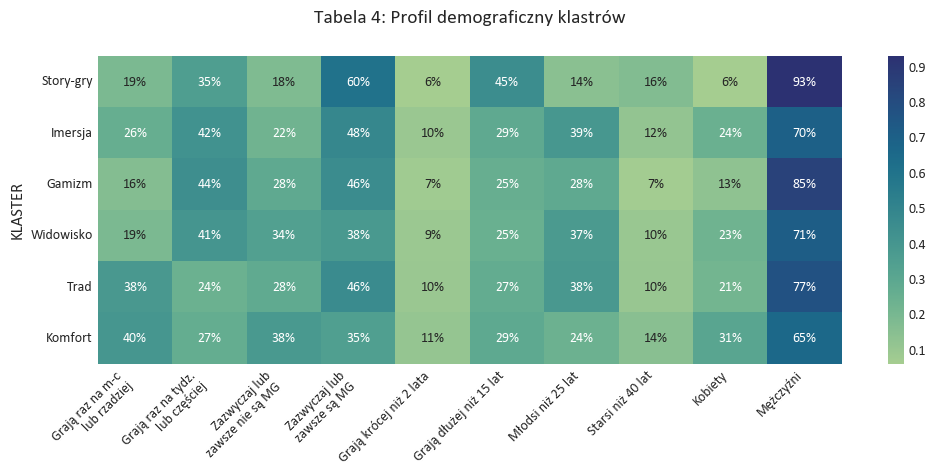

In [9]:
## Tabela 4: Profil demograficzny klastrów

cq_preproc = pd.DataFrame({
    'CLUSTER': kmeans.labels_,
    'INFREQ': control_q['CQ_PLAY_FREQ'] < 3,
    'FREQ': control_q['CQ_PLAY_FREQ'] > 3,
    'NON_GMS': control_q['CQ_GM_FREQ'] < 3,
    'GMS': control_q['CQ_GM_FREQ'] > 3,
    'ROOKIES': control_q['CQ_TENURE'] < 2,
    'GROGNARDS': control_q['CQ_TENURE'] > 4,
    'YOUNG': control_q['CQ_AGE'] < 3,
    'OLD': control_q['CQ_AGE'] > 4,
    'WOMEN': control_q['CQ_SEX'] == 1,
    'MEN': control_q['CQ_SEX'] == 2,
})[is_not_outlier]

plt.figure(figsize=(12,4))
ax = sb.heatmap(cq_preproc.groupby('CLUSTER').agg(lambda x: x.sum() / len(x)), cmap='crest', annot=True, fmt='.0%', annot_kws={'fontsize': 10})
ax.set_title('Tabela 4: Profil demograficzny klastrów', fontsize=14, pad=24)
ax.set_ylabel('KLASTER', fontsize=12)
ax.set_yticklabels(cluster_names)
ax.tick_params(axis='y', rotation=0)
plt.xticks(rotation=45, ha='right')
ax.set_xticklabels([
    'Grają raz na m-c\nlub rzadziej',
    'Grają raz na tydz.\nlub częściej',
    'Zazwyczaj lub\nzawsze nie są MG',
    'Zazwyczaj lub\nzawsze są MG',
    'Grają krócej niż 2 lata',
    'Grają dłużej niż 15 lat',
    'Młodsi niż 25 lat',
    'Starsi niż 40 lat',
    'Kobiety',
    'Mężczyźni',
])
plt.show()

In [10]:
## Obliczenie "odchylenia światopoglądowego" klastrów wraz z istotnością statystyczną (test t Studenta, p < .05)

mfq_means = mfq.mean()
mfq_clustered = mfq.assign(CLUSTER=kmeans.labels_)[is_not_outlier]

clusters = sorted(mfq_clustered['CLUSTER'].unique())
p_values = pd.DataFrame(index=clusters, columns=mfq.columns)

for cluster in clusters:
    for param in mfq.columns:
        cluster_values = mfq_clustered[mfq_clustered['CLUSTER'] == cluster][param]
        p_values.loc[cluster, param] = stats.ttest_1samp(cluster_values, mfq_means[param])[1]

mfq_diff_from_mean = mfq_clustered.groupby('CLUSTER').mean().transpose().apply(lambda x: x - mfq_means[x.name], axis=1)

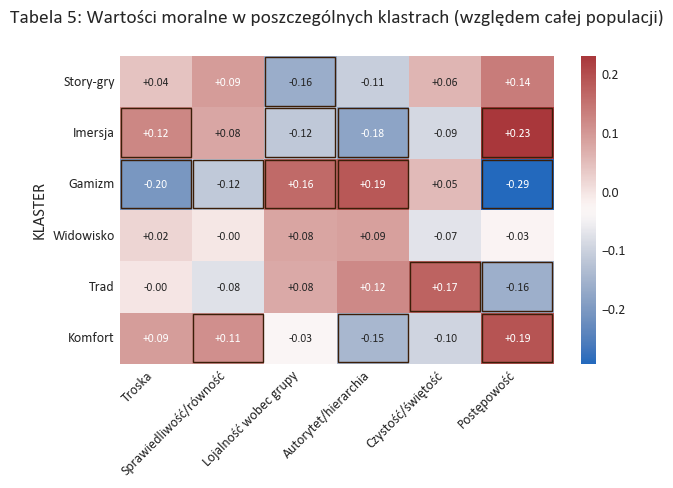

In [11]:
## Tabela 5: Wartości moralne w poszczególnych klastrach

plt.figure(figsize=(7,4))
ax = sb.heatmap(mfq_diff_from_mean.transpose(), cmap='vlag', annot=True, fmt='+.2f', annot_kws={'fontsize': 'small'})

for i in range(len(mfq.columns)):
    for j in range(len(clusters)):
        if p_values.iloc[i, j] < .05:
            ax.add_patch(Rectangle((j+0.01, i+0.02), 0.97, 0.95, fill=False, lw=1, edgecolor='#3b1e08'))
            
ax.set_title('Tabela 5: Wartości moralne w poszczególnych klastrach (względem całej populacji)', fontsize=14, pad=24)
ax.set_ylabel('KLASTER', fontsize=12)
ax.set_yticklabels(cluster_names)
ax.tick_params(axis='y', rotation=0)
plt.xticks(rotation=45, ha='right')
ax.set_xticklabels([
    'Troska',
    'Sprawiedliwość/równość',
    'Lojalność wobec grupy',
    'Autorytet/hierarchia',
    'Czystość/świętość',
    'Postępowość',
])
plt.show()

In [12]:
## Korelacja wartości z preferencjami erpegowymi, z wyliczeniem istotności (p < 0.05, z poprawką Bonferroniego)

value_rpg_corr = pd.concat([questions, mfq], axis=1).corr().loc[mfq.columns,questions.columns]
p_values = pd.concat([questions, mfq], axis=1).corr(method=lambda x,y: stats.pearsonr(x,y)[1]).loc[mfq.columns,questions.columns]
significant = p_values.applymap(lambda x: min(1.0, x * p_values.size) < 0.05)

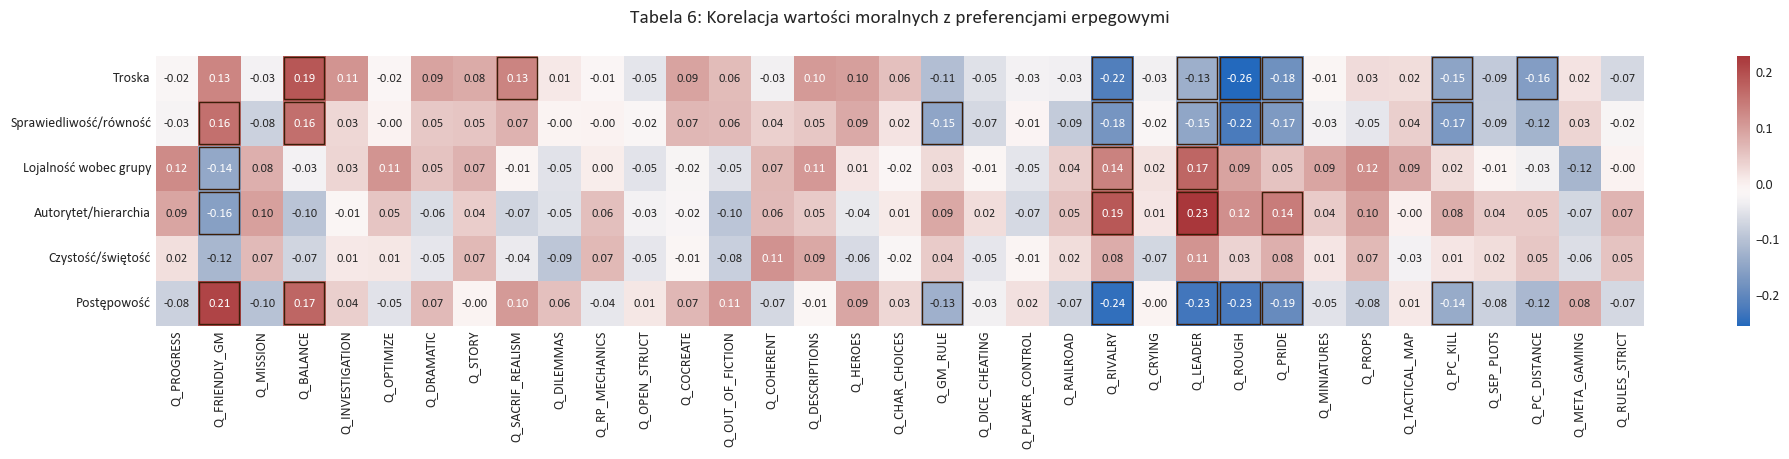

In [13]:
## Tabela 6: Korelacja wartości moralnych z preferencjami erpegowymi

plt.figure(figsize=(24,3.5))
ax = sb.heatmap(value_rpg_corr, cmap='vlag', annot=True, fmt='.2f', annot_kws={'fontsize': 9})

for i in range(len(mfq.columns)):
    for j in range(len(questions.columns)):
        if significant.iloc[i, j]:
            ax.add_patch(Rectangle((j+0.02, i+0.02), 0.94, 0.94, fill=False, edgecolor='#3b1e08', lw=1))

ax.set_title('Tabela 6: Korelacja wartości moralnych z preferencjami erpegowymi', fontsize=14, pad=24)
ax.set_yticklabels([
    'Troska',
    'Sprawiedliwość/równość',
    'Lojalność wobec grupy',
    'Autorytet/hierarchia',
    'Czystość/świętość',
    'Postępowość',
])
ax.tick_params(axis='y', rotation=0)
plt.show()